# An FM Journey

In this chapter, we're going to look at Angular Velocity Modulation in detail.  Angular Velocity Modulation is very commonly used in communications systems, though it's better known under its inexplicable abbreviation, "FM."  I presume it's called "FM" because "AM" was already taken by Amplitude Modulation and "AVM" isn't catchy.

Okay, so we're obviously really talking about Frequency Modulation (FM) here.  But frequency modulation is a bit of a misnomer.  I prefer to think of FM as "angular velocity modulation," as we're not simply modulating the frequency of our signal, but instead modulating its _instantaneous_ frequency.  Let's look at this in more detail, as it's both a bit subtle and very important to understand.

In [ ]:
# %pylab inline
pylab.rcParams["figure.figsize"] = (15,5)

## Basic concepts

The fundamental idea of FM is that we're going to nudge our carrier frequency around in order to convey our signal.  When there's silence, we don't move the frequency at all: there's just a bare carrier transmitted.  Once there's audio to transmit, the amplitude of our input signal is turned into a change in frequency.  If the amplitude is positive, it pulls the carrier up; if the input is negative, it pulls the carrier down.

Note that this requires a mapping function: we have to scale our input amplitude to a range of frequency shifts.  The maximum frequency shift is referred to as the *Frequency Deviation*.  So, if we have a deviation of 5kHz, then an input amplitude of 0.5 will nudge our carrier up $0.5\times5\mathrm{kHz} = 2.5\mathrm{kHz}$.

This seems like a straightforward thing to implement, but there's a gotcha.  We're modulating _instantaneous_ frequency, not the overall frequency.  This means there will be phase drift to account for, so we can't do the naive implementation.  But, hey, there's no better teacher than a mistake, right?  Let's implement things the naive way and see what goes wrong.

In [45]:
# Set up some general stuff for our simulation
Fs = 100000.0
Fc = 10000.0
max_deviation = 5000

Let's start with a simple Binary Frequency-Shift Keying (BFSK) example.  Instead of having a nice sinusoidal audio signal, we'll transmit a square wave of binary data.  This will make it a bit easier to see the problems emerge.

(-0.1, 1.1)

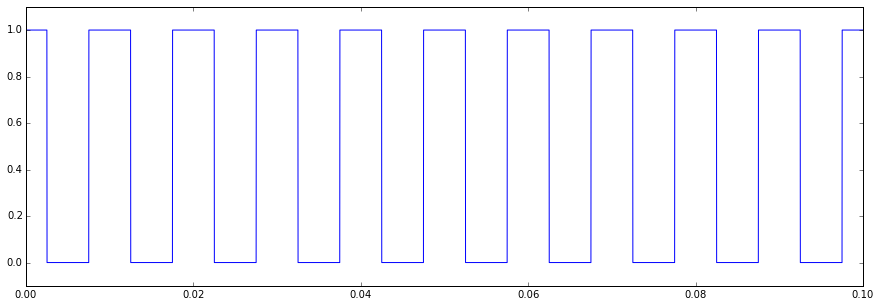

In [105]:
N = 10000
tone = 100
t = np.arange(N+0.0)
signal = (0 < np.cos(t*2*np.pi*tone/Fs))
plot(t/Fs, signal)
ylim(-0.1, 1.1)

And now, let's do a naive frequency modulator:

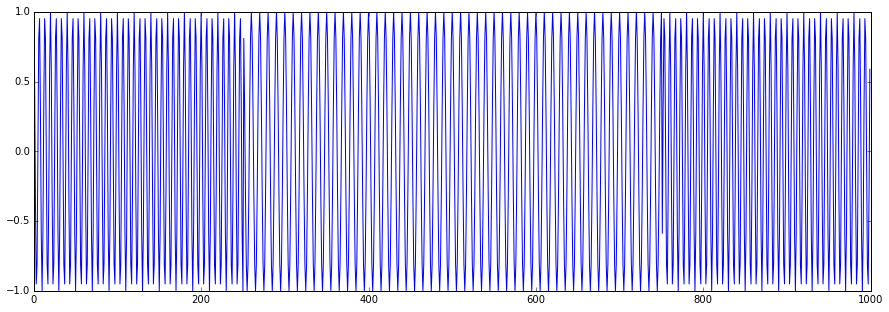

In [106]:
def modulate_frequency_naive(Fs, Fc, deviation, signal):
    "Naive/broken Frequency Modulation of the input signal"
    freq_shifts = deviation * signal
    
    t = np.arange(0.0+len(signal))/Fs
    
    x = np.cos(2*np.pi*t * (Fc+freq_shifts))
    
    return x

bogus_fm = modulate_frequency_naive(Fs, Fc, max_deviation, signal)
plot(bogus_fm[0:1000])

Let's look more closely at the transitions here:

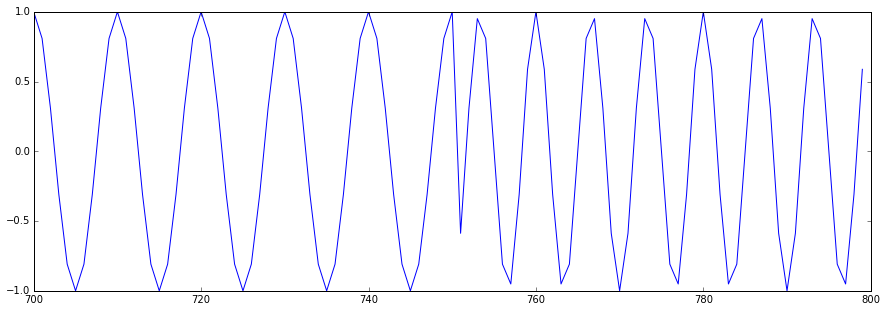

In [82]:
plot(np.arange(700,800), bogus_fm[700:800])

See that glitch at the transition?  That's not supposed to happen!  We should get a smooth sine wave that increases in frequency, not a sudden switch to a different sine wave.  What's gone wrong?  The answer, of course, is that we've suddenly switched to a different sine wave.  But how did that sneak in?

It may be easier to explain if we look at this in terms of the angle at each sample, instead of the output of our sine wave at each sample.  Recall that sine is a periodic function, so $\sin(0) = \sin(2\pi) = \sin(4\pi) = \dots$.  This allows us to think of the angle of our signal as a straight line, with an angle that's related to the frequency.  A higher frequency means we move through the angles faster, so the line has a higher slope.

In this view, a line of constant slope is an unmodulated carrier wave, at some frequency.  For our BFSK example, we expect a zig-zag sort of line, which changes its slope over time, but is connected end-to-end.  Instead, we get the following:

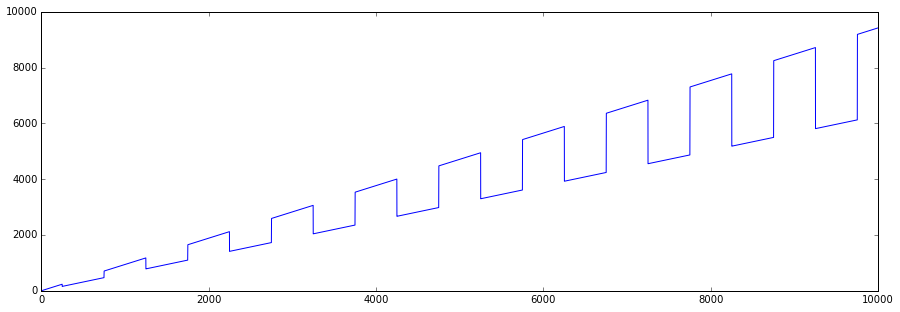

In [84]:
def mod_angle_fm_naive(Fs, Fc, deviation, signal):
    freq_shifts = deviation * signal
    
    t = np.arange(0.0+len(signal))/Fs
    
    return 2*np.pi*t * (Fc+freq_shifts)

bogus_angles = mod_angle_fm_naive(Fs, Fc, max_deviation, signal)

plot(bogus_angles)

This isn't a bunch of lines connected end-to-end: it's two lines with different slopes, and we jump in between the two:

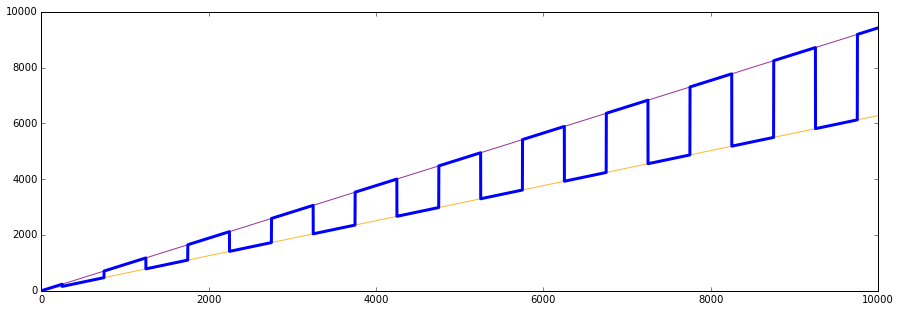

In [94]:
bogus_angles = mod_angle_fm_naive(Fs, Fc, max_deviation, signal)

f_low = mod_angle_fm_naive(Fs, Fc, max_deviation, np.zeros_like(signal)) # all zero
f_high = mod_angle_fm_naive(Fs, Fc, max_deviation, np.zeros_like(signal)+1.0) # all one

plot(f_low, color="orange", alpha=0.8)
plot(f_high, color="purple", alpha=0.8)
plot(bogus_angles, linewidth=3)

This jumping around isn't what we're after.  Those discontinuities mean that our output sinusoid is going to jump around wildly.  To fix this, we need to look at the instantaneous velocity, instead of the overall velocity.  Let's look at that in more detail.

## Accumulating instantaneous velocities

So, let's change the way we do this.  Instead of directly modulating the angle at each point in time, let's modulate the amount of angular change that happens at each point in time.  Then, we accumulate all of those steps up, and use that as the input to our sinusoidal function.

The change in angle over each sample is a direct function of the instantaneous frequency: every cycle is $2\pi$ radians, and we get through $\frac{1}{F_s}$ seconds with each sample.  So, given an instantaneous frequency $f$, our angular change each sample is $2\pi \times f \times \frac{1}{F_s}$ radians. 

In [108]:
def modulate_fm(Fs, Fc, max_deviation, s):
    inst_freqs = Fc + s * max_deviation
    
    phase_shifts = 2*np.pi * inst_freqs / Fs

    m = np.cos(np.cumsum(phase_shifts))
    return m

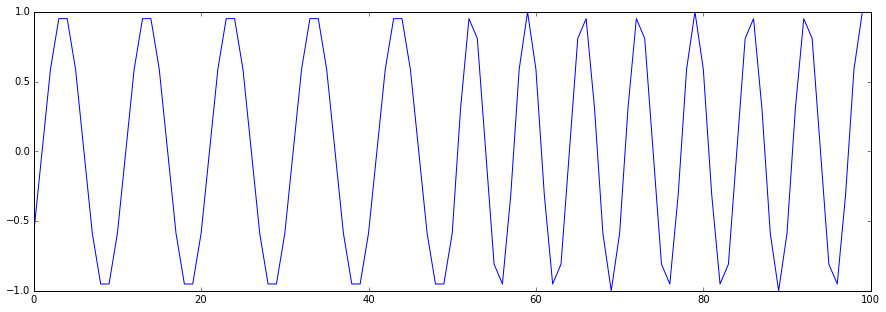

In [109]:
x = modulate_fm(Fs, Fc, max_deviation, signal)

plot(x[700:800])

One last tweak to the modulator before we get to demodulation: let's give ourselves IQ output.  The current signal is real-only, which is a bummer.  All our radio systems are IQ, which gives us complex numbers as input.  So, let's change out that cosine for a complex exponent.  For more details on how/why/what-the-heck, see the trigonometry appendix for why $e^{i\pi} = -1$.

In [104]:
def modulate_fm(Fs, Fc, max_deviation, s):
    inst_freqs = Fc + s * max_deviation
    
    phase_shifts = 2*np.pi * inst_freqs / Fs

    m = np.exp(1.0j * np.cumsum(phase_shifts))
    return m

## Demodulating FM

Correctly demodulating FM is incredibly complex, but we're software people here.  Effective is what we're after.  Theoretical correctness is a nice-to-have.  Effectively demodulating FM is pretty simple: we just need to find the difference in angles between two samples to get the instantaneous frequency.  From there, we unmap it out via the carrier frequency and deviation.

Happily, getting the difference in angle between two IQ samples is a trivial operation.  If you remember the complex arithmetic introduction, you may remember that when we multiply two complex numbers together, their magnitudes multiply and their arguments (angles) add.  So, to take the difference of two angles, we simply get the argument of the multiplication of the complex conjugate of the subtractand.  Simple!



In [9]:
def demod_quad_proper(x):
    y = np.conj(x[:-1])*x[1:]
    return np.arctan2(np.imag(y), np.real(y))

In [8]:
def demod_quad_janky(x):
    y = np.conj(x[:-1])*x[1:]
    return np.imag(y)

In [10]:
k = np.pi*Fs/max_deviation*10

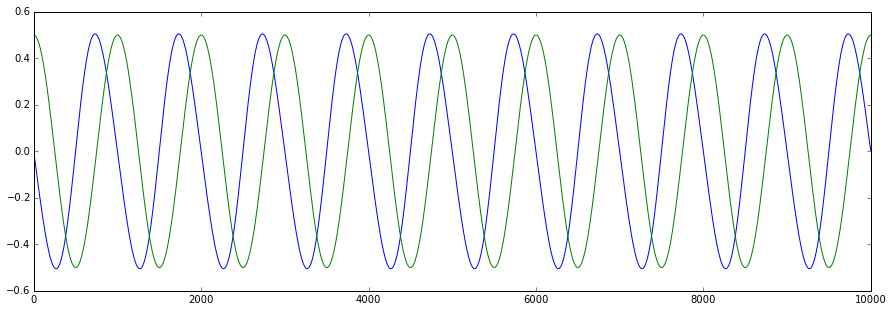

In [13]:
y_janky = np.diff(demod_quad_janky(x))
plot(y_janky*k)
plot(signal)

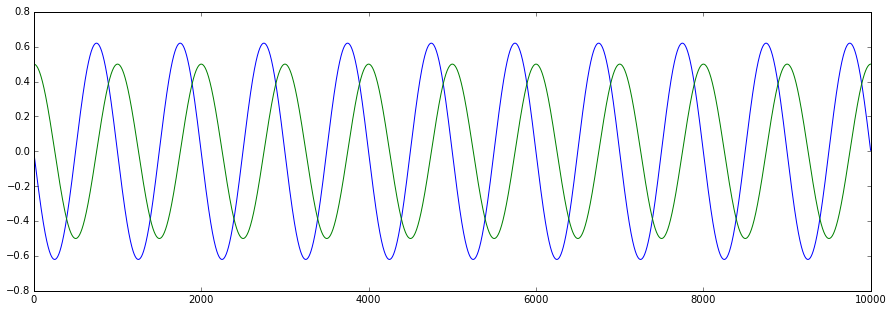

In [17]:
y_proper = np.diff(demod_quad_proper(x))
plot(y_proper*k)
plot(signal)

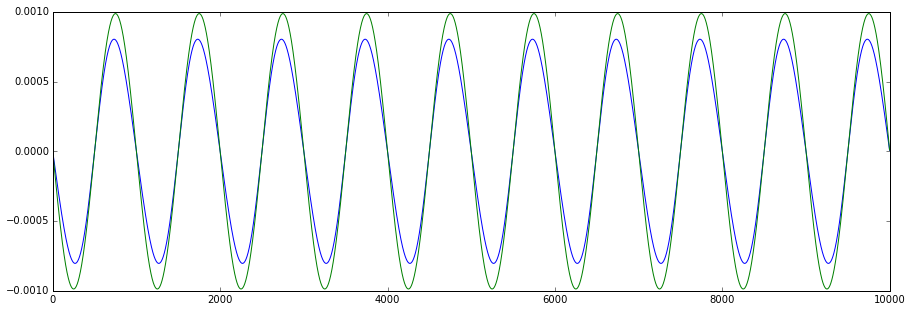

In [18]:
plot(y_janky)
plot(y_proper)

(0, 10000)

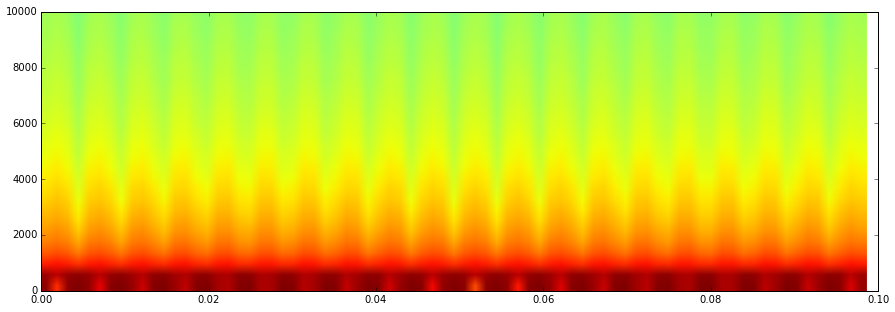

In [19]:
specgram(signal, Fs=Fs); None
ylim(0,10000)

(0, 10000)

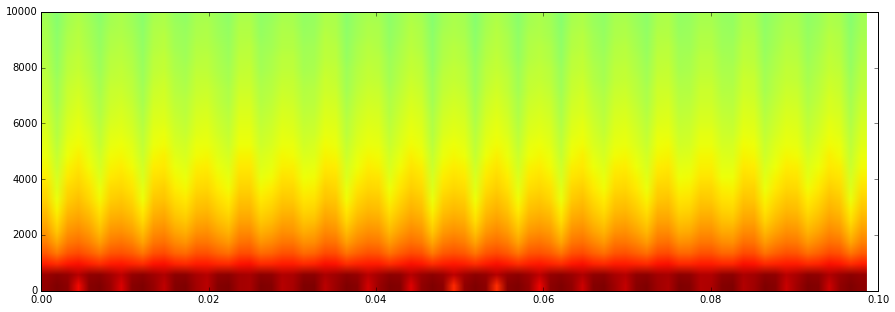

In [20]:
specgram(y_janky, Fs=Fs); None
ylim(0,10000)

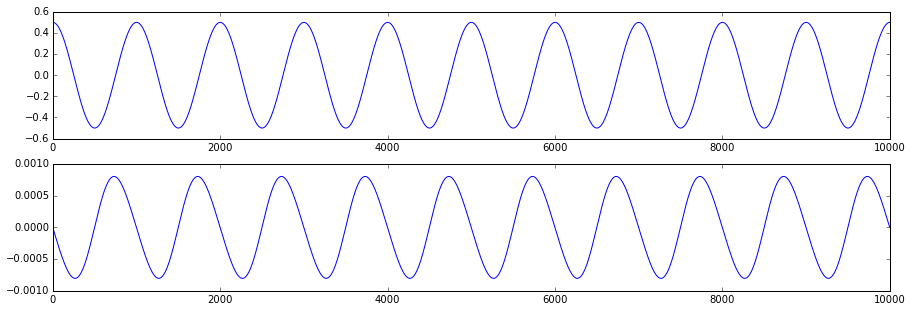

In [21]:
figure(figsize=(15,5))
subplot(2,1,1)
plot(signal)
subplot(2,1,2)
plot(y_janky)

In [37]:
noise = numpy.random.uniform(low=-0.5, high=0.5, size=100000)
t = np.arange(100000.0)

freqs = [ 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

#noise = np.zeros_like(t)
#for f in freqs:
#    noise += 0.1 * np.cos(t*2*np.pi*f/Fs)
#psd(noise, Fs=Fs); None

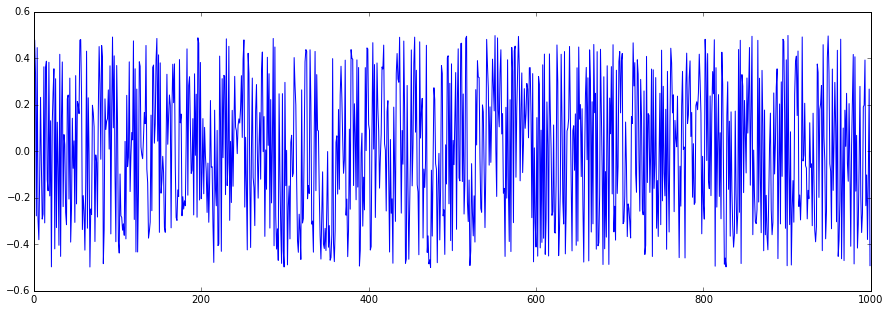

In [38]:
plot(noise[0:1000])

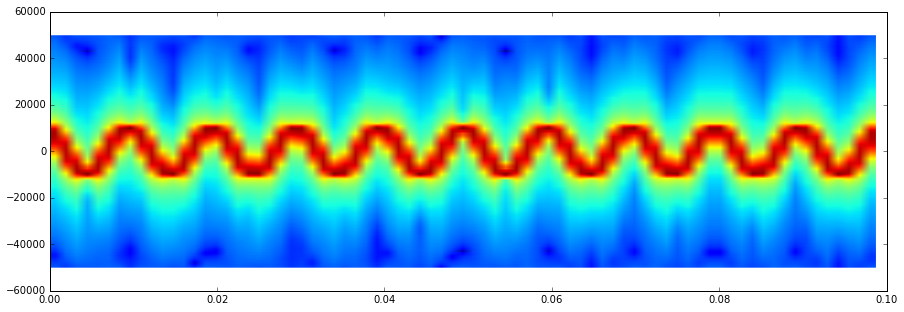

In [39]:
noise_mod = modulate_fm(Fs, 0, 20000, noise)
specgram(noise_mod, Fs=Fs); None

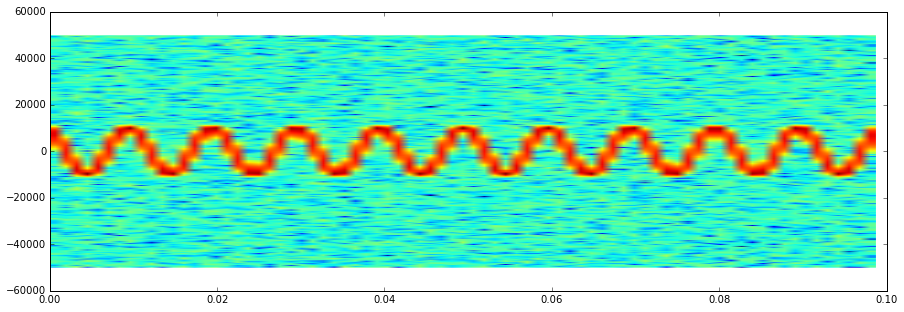

In [40]:
noise_mod_noisy = noise_mod + np.random.normal(scale=0.05, size=len(noise_mod))
specgram(noise_mod_noisy, Fs=Fs); None

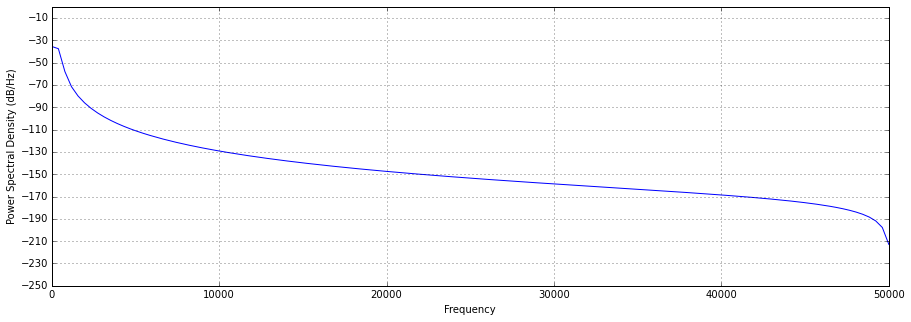

In [41]:
noise_demod = demod_quad_janky(noise_mod)
psd(noise_demod,Fs=Fs); None

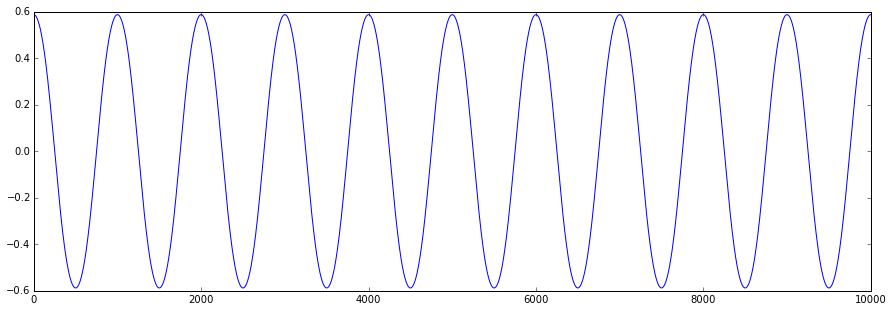

In [42]:
plot(noise_demod)

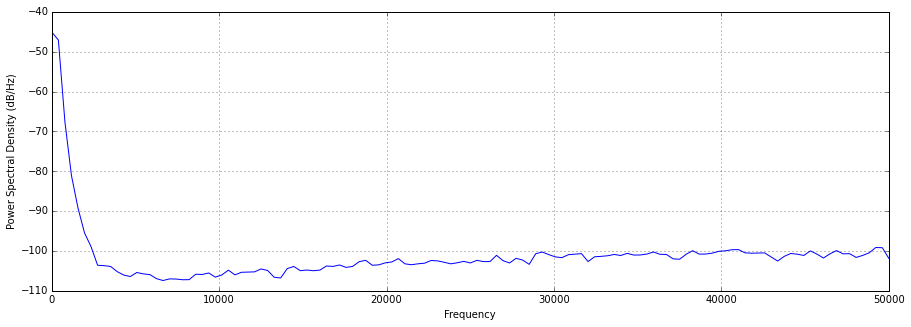

In [28]:
noise_demod_noisy = demod_quad_janky(noise_mod_noisy) / 3
psd(noise_demod_noisy, Fs=Fs); None

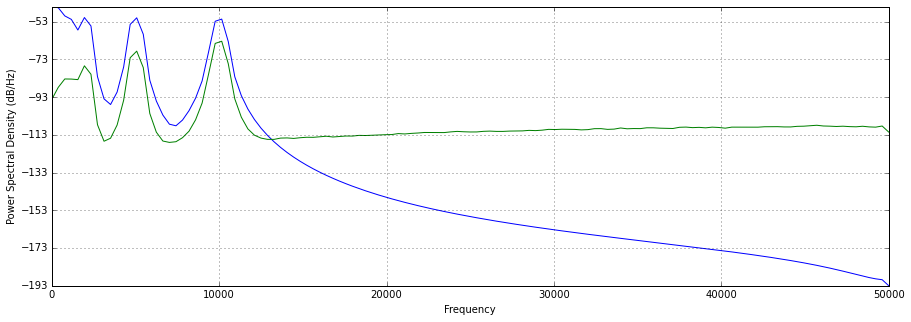

In [251]:
psd(noise, Fs=Fs)
psd(noise_demod_noisy, Fs=Fs); None

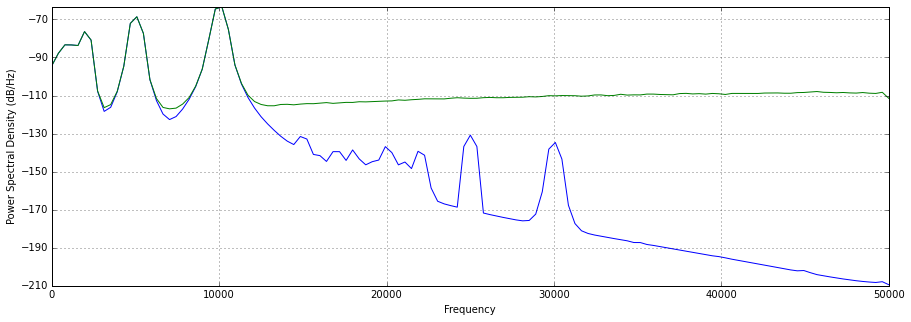

In [252]:
psd(noise_demod, Fs=Fs)
psd(noise_demod_noisy, Fs=Fs); None